In [1]:
import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset
import torch
from PIL import Image
import matplotlib.pyplot as plt

#from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.checkpoint as checkpoint
import torch.utils.data
from torch.utils.data import random_split

import torchio as tio
import torchio.transforms as transforms

from PIL import Image

import random
import math

In [2]:
from tools import crop_tensor

In [3]:
"""
Data loading: Load the BRATS data from different formats (e.g., NIfTI, HDF5).

Data augmentation: Apply common augmentations for medical images, such as rotations, scaling, flipping, and elastic transformations.

Conversion utilities: Convert the data to different formats suitable for different types of models (e.g., 2D, 3D, multi-channel).

Metrics: Implement common segmentation metrics, such as Dice coefficient, Jaccard index, sensitivity, specificity, and Hausdorff distance.

Benchmarks: Include functions to evaluate a model's performance using the above metrics and compare it against benchmark results on the BRATS dataset.

Visualization: Include functions to visualize the original images, ground truth segmentations, and model predictions.
"""

"\nData loading: Load the BRATS data from different formats (e.g., NIfTI, HDF5).\n\nData augmentation: Apply common augmentations for medical images, such as rotations, scaling, flipping, and elastic transformations.\n\nConversion utilities: Convert the data to different formats suitable for different types of models (e.g., 2D, 3D, multi-channel).\n\nMetrics: Implement common segmentation metrics, such as Dice coefficient, Jaccard index, sensitivity, specificity, and Hausdorff distance.\n\nBenchmarks: Include functions to evaluate a model's performance using the above metrics and compare it against benchmark results on the BRATS dataset.\n\nVisualization: Include functions to visualize the original images, ground truth segmentations, and model predictions.\n"

In [5]:
default_augmentations = {
    "random_crop": {
        "size": (72, 72, 72),
        "p": 1.0
    },
    "random_flip": {
        "p": 0.25
    },
    "random_axes_transpose": {
        "p": 0.1
    },
    "random_channel_gauss": {
        "mean" : 0, 
        "std" : 1, 
        "channels" : 4,
        "p": 0.2
    }
}

In [6]:
# Test the main dataset

from dataset import init_train_test_datasets

data_dir = 'C:/Users/alist/WorkCodes/Datasets/BRATS2021TRAINDATASET'
train_dataset, test_dataset = init_train_test_datasets(data_dir, train_ratio = 0.8, normalized=True, is_cropped=True, add_onehot=True, augmentation_config=default_augmentations, add_test_augmentations=False)

print(len(train_dataset), len(test_dataset))

1000 251


In [7]:
# train_dataset.slice_display(0, slice_num = 0)
# test_dataset.montage_display(2, channel = 3, figsize = (3,3))


In [8]:
from pytorch3dunet.unet3d.model import UNet3D

In [9]:
model = UNet3D (in_channels=5, out_channels=4, final_sigmoid=False, f_maps=32, layer_order='cgr',
                 num_groups=8, num_levels=4, is_segmentation=True, conv_padding=1)

In [10]:
# loss functions
class DiceLoss(nn.Module):
    def forward(self, input, target):
        smooth = 1.

        iflat = input.view(-1)
        tflat = target.view(-1)
        intersection = (iflat * tflat).sum()
        
        return 1 - ((2. * intersection + smooth) /
                  (iflat.sum() + tflat.sum() + smooth))

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCELoss()

    def forward(self, input, target):
        return self.alpha * self.dice_loss(input, target) + (1 - self.alpha) * self.bce_loss(input, target)


# If softmax as the final layer

def Dice(output, target, eps=1e-5):
        target = target.float()
        num = 2 * (output * target).sum()
        den = output.sum() + target.sum() + eps
        return 1.0 - num/den

class softmax_dice(nn.Module):
    '''
    The dice loss for using softmax activation function
    :param output: (b, num_class, d, h, w)
    :param target: (b, d, h, w)
    :return: softmax dice loss
    '''
    def __init__(self):
        super(softmax_dice, self).__init__()
        
    def forward(self, output, target):
        target[target == 4] = 3 
        output = output.cuda()
        target = target.cuda()
        loss0 = Dice(output[:, 0, ...], (target == 0).float())
        loss1 = Dice(output[:, 1, ...], (target == 1).float())
        loss2 = Dice(output[:, 2, ...], (target == 2).float())
        loss3 = Dice(output[:, 3, ...], (target == 3).float())

        return loss1 + loss2 + loss3 + loss0 #, 1-loss1.data, 1-loss2.data, 1-loss3.data



In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print (device)

cuda


In [12]:
# Define hyperparameters
learning_rate = 0.001
num_epochs = range(3)

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

# Define loss function and optimizer
criterion = softmax_dice()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Load checkpoint ==============================
#checkpoint = torch.load('checkpoint-1.pth')
#model.load_state_dict(checkpoint['model_state_dict'])
# ==============================================

model.train()

running_loss = 0

for epoch in num_epochs:
    
    running_loss = 0.0
    totalTestLoss = 0

    model.train()

    for counter, (images, labels) in enumerate(train_loader):
        outputs = model(images.cuda())
        images.cpu()

        loss = criterion(outputs.cpu(), labels.long())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        # print("running_loss", loss.item())
        
        if counter % 20 == 19:
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            },  'checkpoint-'+ str(epoch) +'.pth')
            print( "epoch:", epoch, "iteration:", counter, "Average cost function", running_loss/20)
            running_loss = 0

        # Optimizing memory
        del outputs, images
        # torch.cuda.empty_cache()

epoch: 0 iteration: 19 Average cost function 3.6975324630737303
epoch: 0 iteration: 39 Average cost function 2.8269323110580444
epoch: 0 iteration: 59 Average cost function 2.769859719276428
epoch: 0 iteration: 79 Average cost function 2.7400261878967287
epoch: 0 iteration: 99 Average cost function 2.6602885007858275
epoch: 0 iteration: 119 Average cost function 2.6139116168022154
epoch: 0 iteration: 139 Average cost function 2.613149356842041
epoch: 0 iteration: 159 Average cost function 2.5906838059425352
epoch: 0 iteration: 179 Average cost function 2.5570813536643984
epoch: 0 iteration: 199 Average cost function 2.522204065322876
epoch: 0 iteration: 219 Average cost function 2.46750785112381
epoch: 0 iteration: 239 Average cost function 2.3702644526958467
epoch: 0 iteration: 259 Average cost function 1.9359726816415788
epoch: 0 iteration: 279 Average cost function 2.4963000774383546
epoch: 0 iteration: 299 Average cost function 2.473071312904358
epoch: 0 iteration: 319 Average cost

KeyboardInterrupt: 

IoU: 0.3320318100358423


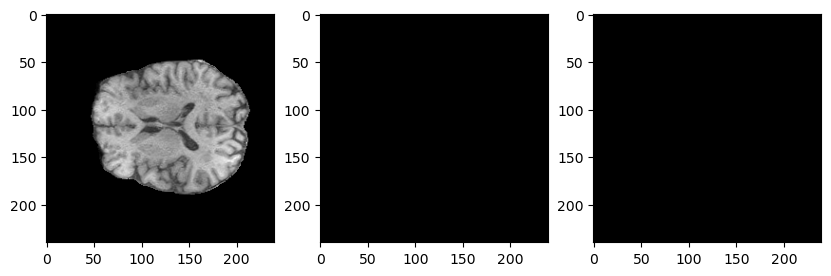

IoU: 0.3279348491636798


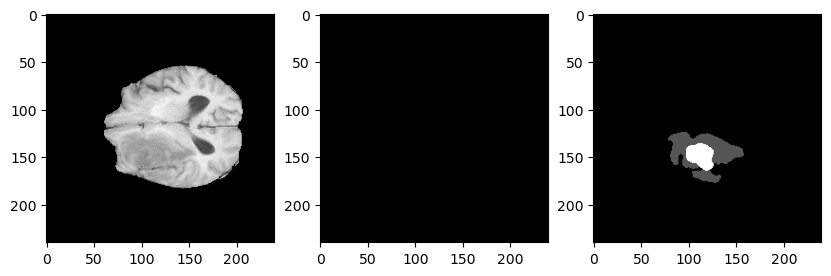

IoU: 0.3273014859617682


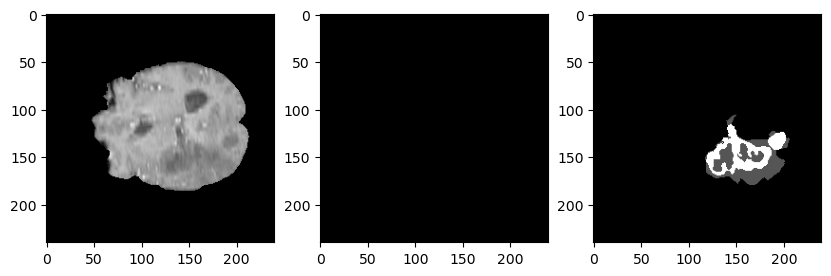

IoU: 0.328914538530466


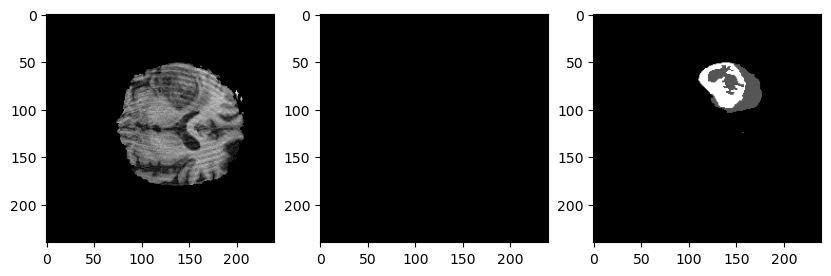

IoU: 0.3323656287335723


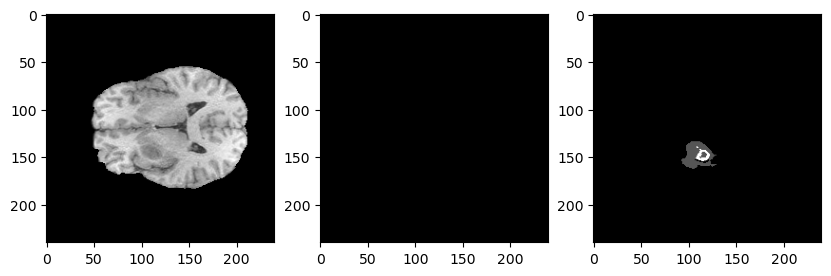

IoU: 0.33084498207885304


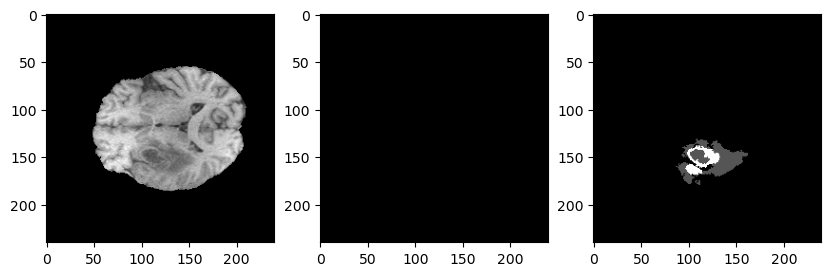

KeyboardInterrupt: 

In [12]:
"""
A few examples
"""

from sklearn.metrics import jaccard_score

checkpoint = torch.load('checkpoint-1.pth')
model.load_state_dict(checkpoint['model_state_dict'])

for i in test_dataset:
    scan = i[0].unsqueeze(dim = 0) # => [1, 4, 240, 240, 155]
    mask = i[1]

    model.eval()
    layer = 70

    out = model(scan.to(device))

    class_index = torch.argmax(out, dim=1).cpu()
    iou = jaccard_score(mask.flatten(), class_index.flatten(), average='macro')
    print(f"IoU: {iou}")
    
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))    
    axs[0].imshow(scan[0][0][:, :,layer].cpu().detach().numpy(), cmap='gray')
    axs[1].imshow(class_index[0][:, :, layer].cpu().detach().numpy(), cmap='gray')
    axs[2].imshow(mask[:, :, layer].cpu().detach().numpy(), cmap='gray')
    plt.show()

    # Delete variables
    del scan, mask, out, class_index
    # Empty the cache
    torch.cuda.empty_cache()

In [12]:
checkpoint = torch.load('checkpoint-1.pth')
model.load_state_dict(checkpoint['model_state_dict'])

out = model(test_dataset[0][0].unsqueeze(dim = 0).to(device))

In [45]:
out.cpu().argmax(dim=1)[0].sum()

tensor(6)

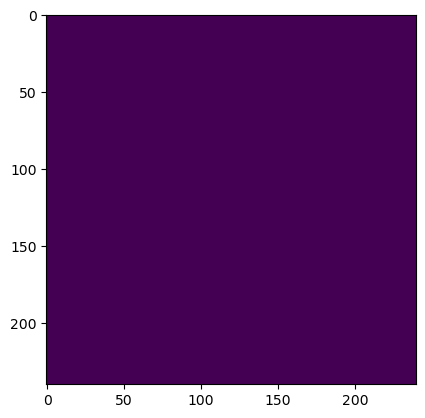

In [41]:
a = out.cpu().argmax(dim=1)[0]
plt.imshow(a.cpu()[:, :, 1])
plt.show()
